In [5]:
import tensorflow as tf
import keras
from keras import models, layers
import matplotlib.pyplot as plt
import os

#### Constants


In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

#### Importing Dataset


In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/New plant disease/",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 70295 files belonging to 38 classes.


In [8]:
class_names = dataset.class_names

In [9]:
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

### Sample Images


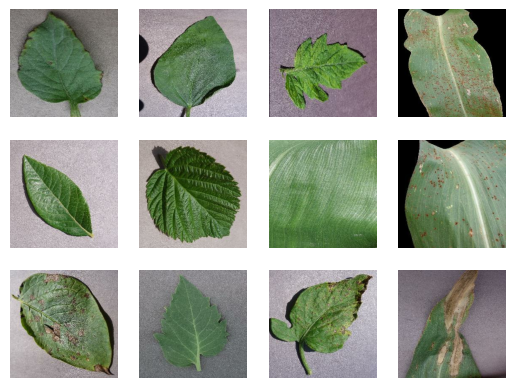

In [10]:
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
def get_dataset_partition(
    dataset,
    train_size=0.8,
    validation_size=0.1,
    test_size=0.1,
    shuffle=False,
    shuffle_size=10000,
):
    assert (train_size + validation_size + test_size) == 1

    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_size * dataset_size)
    validation_size = int(validation_size * dataset_size)
    test_size = int(test_size * dataset_size)

    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)

    return train_dataset, validation_dataset, test_dataset

### Dividing Dataset into Train, Test and Validation


In [12]:
train_dataset, validation_dataset, test_dataset = get_dataset_partition(dataset)

In [8]:
# train_dataset = (
#     train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# )
# validation_dataset = (
#     validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# )
# test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Rescaling and Resizing Images


In [9]:
resize_and_scale = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        tf.keras.layers.Rescaling(1.0 / 255),
    ]
)

#### Data Augmentation for Increasing Dataset Size and Preventing Overfitting


In [10]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

### Building Model using CNN


In [11]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
number_of_classes = len(class_names)
model = models.Sequential(
    [
        resize_and_scale,
        data_augmentation,
        tf.keras.layers.Conv2D(
            32, kernel_size=(3, 3), activation="relu", input_shape=INPUT_SHAPE
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(number_of_classes, activation="softmax"),
    ]
)

model.build(input_shape=INPUT_SHAPE)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

### Compiling Model using Adam Optimizer and Categorical Crossentropy Loss Function


In [13]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

### Using Tensorboard for Visualization


In [14]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="./logs", histogram_freq=1
)

### Training Model


In [15]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    # verbose="1",
    epochs=EPOCHS,
)

Epoch 1/25
1757/1757 [==============================] - 374s 207ms/step - loss: 1.9192 - accuracy: 0.4363 - val_loss: 1.3192 - val_accuracy: 0.6123
Epoch 2/25
1757/1757 [==============================] - 345s 196ms/step - loss: 0.6766 - accuracy: 0.7817 - val_loss: 0.9327 - val_accuracy: 0.7132
Epoch 3/25
1757/1757 [==============================] - 343s 195ms/step - loss: 0.4712 - accuracy: 0.8467 - val_loss: 0.5992 - val_accuracy: 0.8054
Epoch 4/25
1757/1757 [==============================] - 343s 195ms/step - loss: 0.3648 - accuracy: 0.8828 - val_loss: 0.6180 - val_accuracy: 0.8081
Epoch 5/25
1757/1757 [==============================] - 343s 195ms/step - loss: 0.3162 - accuracy: 0.8948 - val_loss: 0.5544 - val_accuracy: 0.8231
Epoch 6/25
1757/1757 [==============================] - 343s 195ms/step - loss: 0.2716 - accuracy: 0.9104 - val_loss: 0.4601 - val_accuracy: 0.8470
Epoch 7/25
1757/1757 [==============================] - 343s 195ms/step - loss: 0.2476 - accuracy: 0.9179 - val_

In [16]:
# %tensorboard --logdir logs

### Saving Model


In [17]:
model_version = max([int(i) for i in os.listdir("./Model") + [0]]) + 1
model.save(f"./Model/{model_version}")

INFO:tensorflow:Assets written to: ./Model/3\assets


INFO:tensorflow:Assets written to: ./Model/3\assets
